%load_ext autoreload
%autoreload 2

In [399]:
from chiscrape import *
import util
import numpy as np
import seaborn as sns
import matplotlib as mpl
import chiscrape
import util
import networkx as nx
import pandas as pd
import urllib
import matplotlib.pyplot as plt
%matplotlib inline
import re
pd.set_option('max_colwidth',110)
pd.options.display.max_rows = 999
from bs4 import BeautifulSoup
import requests

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


def bar_chart(labels, values, title = '', xaxis = '', yaxis = '', xsize = 14, subtitle=''):
    d = [go.Bar(
            x=labels,
            y=values,
            text=values,
            textposition = 'outside',
            opacity=1)]

    layout = go.Layout(
        title='<b>'+title+'</b><br>'+subtitle,
        xaxis=dict(
            title=xaxis,
            tickfont=dict(
                size=xsize,
                color='rgb(107, 107, 107)'
            )
        ),
        yaxis=dict(
            title=yaxis,
            titlefont=dict(
                size=16,
                color='rgb(107, 107, 107)'
            ),
            tickfont=dict(
                size=14,
                color='rgb(107, 107, 107)'
            )
        ),
    )

    fig = go.Figure(data=d, layout=layout)
    iplot(fig, filename='color-bar')

def viz(groupby_df, title = '', xaxis = '', yaxis = '', xsize = 14, subtitle=''):
    labels = list(groupby_df.index)
    values = list(groupby_df.values)
    l = []
    for dept in labels:
        if 'Department of' in dept:
            new_dept = dept.split('Department of ')[-1]
            l.append(new_dept)
        else:
            l.append(dept)
    labels = l

    d = [go.Bar(
            x=labels,
            y=values,
            text=values,
            textposition = 'outside',
            opacity=1)]

    layout = go.Layout(
        title='<b>'+title+'</b><br>'+subtitle,
        xaxis=dict(
            title=xaxis,
            tickfont=dict(
                size=xsize,
                color='rgb(107, 107, 107)'
            )
        ),
        yaxis=dict(
            title=yaxis,
            titlefont=dict(
                size=16,
                color='rgb(107, 107, 107)'
            ),
            tickfont=dict(
                size=14,
                color='rgb(107, 107, 107)'
            )
        ),
    )

    fig = go.Figure(data=d, layout=layout)
    iplot(fig, filename='color-bar')

def viz2(groupby_df, title = '', xaxis = '', yaxis = '', xsize = 14, subtitle=''):
    labels = list(groupby_df.index)
    values = list(groupby_df['sum'])
    l = []
    for dept in labels:
        if 'Department of' in dept:
            new_dept = dept.split('Department of ')[-1]
            l.append(new_dept)
        else:
            l.append(dept)
    labels = l
    
    d = [go.Bar(
            x=labels,
            y=values,
            text=values,
            textposition = 'outside',
            opacity=1)]

    layout = go.Layout(
        title='<b>'+title+'</b><br>'+subtitle,
        xaxis=dict(
            title=xaxis,
            tickfont=dict(
                size=xsize,
                color='rgb(107, 107, 107)'
            )
        ),
        yaxis=dict(
            title=yaxis,
            titlefont=dict(
                size=16,
                color='rgb(107, 107, 107)'
            ),
            tickfont=dict(
                size=14,
                color='rgb(107, 107, 107)'
            )
        ),
    )

    fig = go.Figure(data=d, layout=layout)
    iplot(fig, filename='color-bar')

In [199]:
path = "C:/Users/vanguiano/Desktop/CoCWebsite/chiscrape/data/run_on_2_6_1_14/"
data = pd.read_csv(path+'data_output_2_6_1_14.csv', encoding = 'iso-8859-1', index_col = 0)
data.index.name = 'index'
unique_domains = pd.read_csv(path+'unique_domains_2_6_1_14.csv', encoding = 'iso-8859-1', index_col = 0)
dead_links = pd.read_csv(path+'dead_links_2_6_1_14.csv', index_col = 0)

## Clean and Update Department Names

In [200]:
def get_department(url):
    try:
        m = re.search('depts/(.+?)/', url).group(1)
    except:
        try:
            m = re.search('depts/(.+?)\.', url).group(1)
        except:
            return 'None'

    return m

In [201]:
urls = list(data.url)
depts = []
for url in urls:
    depts.append((get_department(url),url))

In [202]:
#validate department extraction from url before appending to data
check = pd.DataFrame(depts, columns = ['dept', 'url'], index=list(range(1,len(data)+1)))

In [203]:
#replace department column in data with cleaner more accurate column
data['dept'] = check.dept

In [204]:
#flag for services websites
data['services'] = data.url.str.contains('svcs')

In [205]:
#Clean and strip title
data['title'] = data.title.fillna('None')
cleaned = [title.strip() for title in list(data.title)]
data['title'] = cleaned

In [206]:
#import dept reference table and create reference dictionary
dept_ref = pd.read_csv("C:/Users/vanguiano/Desktop/CoCWebsite/chiscrape/data/dept_reference.csv")
dept_ref_dict = {}
for index in dept_ref.index:
    dept_ref_dict[dept_ref.iloc[index][0]] = dept_ref.iloc[index][1]

In [207]:
#Create dept_name column which looks at dept column and uses reference dictionary to get full name of department
data['dept_name'] = data.dept.apply(lambda x: dept_ref_dict.get(x,'Other'.strip()))

## Top Words

In [11]:
def top_words(description_words, top_num):
    word_dict = {}
    for word in description_words:
        if word not in word_dict:
            word_dict[word] = 1
        else:
            word_dict[word] += 1

    for word, count in word_dict.items():
        word_counts = [(word_dict[word], word) for word in word_dict]

    word_counts.sort()
    word_counts.reverse()

    return word_counts[:top_num]

In [12]:
data['description_words'] = data.description_words.fillna('')
all_words = []
for words in data.description_words.get_values():
    all_words.append(top_words(words.split(';'),5))

In [13]:
data['top_words'] = all_words
data

dept  \
index              
1           None   
2            311   
3            oem   
4          mayor   
5          mayor   
6          mayor   
7            dhr   
8          bldgs   
9           bacp   
10         other   
11           dhr   
12           dhr   
13         other   
14         other   
15          cdph   
16          None   
17       streets   
18         bldgs   
19         bldgs   
20         bldgs   
21         bldgs   
22          mopd   
23           fin   
24           dcd   
25          cdot   
26         bldgs   
27          None   
28       streets   
29           dps   
30          bacp   
31         bldgs   
32         other   
33          cdph   
34         other   
35         mayor   
36          None   
37           fin   
38          bacp   
39           fin   
40         other   
41         bldgs   
42           dgs   
43           dps   
44         other   
45           fin   
46          None   
47          cchr   
48         other   
49           oem   
50         other   
51          mopd   
52          bacp   
53          cdph   
54          None   
55         bldgs   
56       streets   
57          bacp   
58         other   
59          copa   
60          bacp   
61           dps   
62          cdot   
63          cacc   
64          None   
65         bldgs   
66       streets   
67       streets   
68           fin   
69          cdot   
70       streets   
71          cdph   
72           fin   
73          None   
74           oem   
75           cpd   
76           oem   
77          cdph   
78         mayor   
79           fin   
80          None   
81          None   
82          None   
83          None   
84          None   
85          None   
86           311   
87          None   
88           311   
89           311   
90           311   
91           311   
92           311   
93           311   
94           311   
95           311   
96           311   
97           311   
98           311   
99          None   
100         None   
101          oem   
102          cpd   
103          cfd   
104          fin   
105          oem   
106          oem   
107         None   
108        mayor   
109        mayor   
110        mayor   
111        mayor   
112        mayor   
113        mayor   
114          dhr   
115          dhr   
116          dhr   
117         None   
118         None   
119         None   
120        bldgs   
121        bldgs   
122        bldgs   
123        bldgs   
124         None   
125         None   
126         None   
127         None   
128         None   
129         None   
130         bacp   
131         bacp   
132         bacp   
133         bacp   
134         bacp   
135         bacp   
136         bacp   
137         bacp   
138         bacp   
139         bacp   
140         bacp   
141         bacp   
142         bacp   
143         bacp   
144         bacp   
145         bacp   
146         bacp   
147         bacp   
148         None   
149         None   
150         None   
151        other   
152        other   
153        other   
154         None   
155         None   
156         None   
157         None   
158         None   
159         None   
160          fin   
161          fin   
162          dhr   
163          dhr   
164          dhr   
165        other   
166        other   
167         None   
168        other   
169        other   
170         None   
171         None   
172         cdph   
173         cdph   
174         None   
175         cdph   
176         cdph   
177         cdph   
178          dol   
179         cdph   
180         cdph   
181         cdph   
182         cdph   
183         cdph   
184         cdph   
185         cdph   
186         cdph   
187         cdph   
188         cdph   
189         cdph   
190         cdph   
191         cdph   
192          dhr   
193        bldgs   
194        bldgs   
195         mopd   
196        bldgs   
197          fss   
198        bldgs   
199         

In [14]:
digestable_data = data[['dept_name', 'title', 'url', 'services','button', 'i_want_to', 'nav',
       'num_email_addresses', 'email_addresses', 'pdf_count',
       'ext_link_count', 'outside_domain', 'top_words']]
digestable_data.to_csv('data_output.csv')

## Services Flag from Full Services List

In [208]:
apply_for = 'https://www.cityofchicago.org/city/en/svcs/iwantto.apply_for.html'
check_status_of = 'https://www.cityofchicago.org/city/en/svcs/iwantto.check_status_of.html'
find_get = 'https://www.cityofchicago.org/city/en/svcs/iwantto.find_get.html'
pay_for_buy = 'https://www.cityofchicago.org/city/en/svcs/iwantto.pay_for_buy.html'
register = 'https://www.cityofchicago.org/city/en/svcs/iwantto.register.html'
report_file = 'https://www.cityofchicago.org/city/en/svcs/iwantto.report_file.html'
request = 'https://www.cityofchicago.org/city/en/svcs/iwantto.request.html'
sign_up = 'https://www.cityofchicago.org/city/en/svcs/iwantto.sign_up_for_volunteer.html'
pages = [apply_for, check_status_of, find_get, pay_for_buy, register, report_file, request, sign_up]

In [209]:
def filter_urls(urls, true_url):
    limiting_domain = 'cityofchicago.org'
    limiting_path = ''
    ignore = []
    full_urls = []
    for url in urls:
        url = util.remove_fragment(url)
        if url == '':
            continue
        if 'mailto' in url:
            continue
        if not util.is_absolute_url(url):
            url = util.convert_if_relative_url(true_url, url)
            if 'content' in url:
                url = url.split('/content')[0] + url.split('/content')[1]
            full_urls.append(url)
        if util.is_url_ok_to_follow(url, limiting_domain, limiting_path, ignore):
            if 'content' in url:
                url = url.split('/content')[0] + url.split('/content')[1]
            full_urls.append(url)

    return full_urls

In [210]:
d = {}
for page in pages:
    req = requests.get(page)
    true_url = util.get_request_url(req)
    soup = request_to_soup(req, true_url)
    body = soup.find_all('div', class_='col-sm-12 col-md-9 page-center')[0]
    links = get_urls(body)
    urls = filter_urls(links, true_url)[2:]
    name = page.split('.')[-2]
    d[name] = urls 

In [211]:
def label(url, pages):
    lab = ''
    for page in pages.keys():
        if url in pages[page]:
            lab += page + ';'
    if lab:
        return lab[:-1]     

In [212]:
data['in_directory'] = data.url.apply(lambda x: label(x, d))

## Merge with Manual Data

In [213]:
path = 'C:/Users/vanguiano/Desktop/CoCWebsite/chiscrape/data/'
verbs = pd.read_excel(path + 'CoC__Departments_Research_TK_030918_Edits.xlsx', index_col = 0, encoding = 'iso-8859-1')
verbs = verbs.fillna('')

In [215]:
columns = ['dept', 'title', 'url', 'persona', 'orig_verb','verb',
       'service', 'button', 'i_want_to', 'nav',
       'email_count', 'emails', 'pdf_count',
       'external_count', 'external_urls', 'top_words']
verbs.columns = columns
data = pd.merge(data, verbs[['persona','orig_verb','verb']], how ='left', left_index = True, right_index = True)
data = data[['dept_name', 'title', 'url', 'button', 'i_want_to', 'nav', 'services',
       'num_email_addresses', 'email_addresses', 'pdf_count', 'pdf_urls',
       'ext_link_count', 'ext_links', 'outside_domain', 'description_words', 'in_directory', 'persona', 'orig_verb',
       'verb']]

In [217]:
data.to_csv('data/data_output_2_6_1_14_cleaned.csv',sep='`')

## PDF Counts

In [35]:
pdf_counts = data.groupby('dept_name')['pdf_count'].agg(['count','sum'])
pdf_counts = pdf_counts.sort_values('sum',ascending=False)
pdf_counts.columns = [['Number of Web Pages', 'Total PDFs']]
pdf_counts = pdf_counts.rename_axis('Department Name')
pdf_counts = pdf_counts.reset_index()
pdf_counts.to_csv('departments_pdf_counts.csv', index=False)
pdf_counts

Department Name  \
0                       Department of Procurement Services   
1                   Department of Planning and Development   
2                           Department of Water Management   
3                                          Board of Ethics   
4                            Department of Human Resources   
5   Department of Business Affairs and Consumer Protection   
6                              Department of Public Health   
7                                                     None   
8                                    Department of Finance   
9                          Office of Budget and Management   
10                           Commission on Human Relations   
11                                 Department of Buildings   
12                 Department of Innovation and Technology   
13                                    Chicago Police Board   
14                                     Office of the Mayor   
15                            Department of Transportation   
16       Department of Cultural Affairs and Special Events   
17                               License Appeal Commission   
18                 Department of Family & Support Services   
19                   Department of Animal Care and Control   
20                                       Department of Law   
21                    Department of Streets and Sanitation   
22                                 Chicago Fire Department   
23                   Emergency Management & Communications   
24                   Department of Administrative Hearings   
25             Department of Fleet and Facility Management   
26             Mayor's Office for People with Disabilities   
27                                                   Other   
28                                       311 City Services   
29                Civilian Office of Police Accountability   
30                                  Department of Aviation   
31                                Department of Compliance   
32                                      City of Chicago TV   
33                                  Chicago Public Library   
34                         Office of the Inspector General   
35                               Chicago Police Department   

    Number of Web Pages  Total PDFs  
0                   299        6852  
1                   546        6619  
2                   149        2596  
3                   137        2428  
4                   126        2365  
5                   294        1753  
6                   288        1698  
7                  1585        1672  
8                   311         913  
9                    70         478  
10                   59         433  
11                  175         390  
12                  100         310  
13                   20         265  
14                  186         234  
15                  196         229  
16                  600         191  
17                   24         189  
18                  198         184  
19                   49         183  
20                  161         182  
21                  158         176  
22                   54          76  
23                   96          39  
24                   57          25  
25                   45          25  
26                   92          18  
27                   72           8  
28                   27           7  
29                    9           2  
30                   11           1  
31                    1           0  
32                   12           0  
33                   16           0  
34                   12           0  
35                   19           0

## Create full list of PDFS

In [36]:
data.pdf_urls = data.pdf_urls.fillna('None')
pdf_links_list = []
for index in data.index[data.pdf_urls != 'None']:
    pdf_links_list.append((data.dept_name[index],data.url[index],data.pdf_urls[index]))
full_pdf_links_list = []
for page in pdf_links_list:
    for url in page[2].split(';'):
        full_pdf_links_list.append((page[0],page[1],url.strip()))
all_pdfs = pd.DataFrame(full_pdf_links_list, columns = ['dept', 'from_url', 'pdf_url'])
all_pdfs.to_csv('all_Chicago_pdfs.csv',index=False)
all_pdfs_nodup = all_pdfs.drop_duplicates(subset='pdf_url')
all_pdfs_nodup.to_csv('all_Chicago_pdfs_nodups.csv', index = False)

## Unique Domains Dataset

In [43]:
def create_index_by_page_and_ext_domain(data):
    new_dataset = []
    for page in range(len(data)):
        page_index = data.loc[page+1].name
        page_url = data.get_value(page+1, 'url')
        page_dept = data.get_value(page+1, 'dept_name')
        urls = data.get_value(page+1, 'ext_links').split(';')
        unique_domains = get_unique_domains(urls)
        for unique_domain in unique_domains:
            if 'www.' in unique_domain:
                unique_domain = unique_domain[4:]
            urls_in_domain = []
            for url in urls:
                if unique_domain in url:
                    urls_in_domain.append(url)
                    
            new_dataset.append((page_index, page_dept, page_url, unique_domain, len(urls_in_domain), '; '.join(urls_in_domain)))
    df = pd.DataFrame(new_dataset, columns = ['url_index','dept', 'url', 'unique_domain', 'num_links', 'links'])
    return df
        
    

In [44]:
data['ext_links'] = data.ext_links.fillna('')

In [45]:
unique_domains = create_index_by_page_and_ext_domain(data)
unique_domains.to_csv('unique_domains_by_dept.csv', index=False)

In [52]:
unique_domains[unique_domains.unique_domain.str.contains(".cityofchicago")].groupby(['unique_domain']).size().sort_values(ascending=False)

unique_domain
data.cityofchicago.org                                      904
servicetracker.cityofchicago.org                            539
servicerequest.cityofchicago.org                            507
digital.cityofchicago.org                                   494
techplan.cityofchicago.org                                  490
webapps1.cityofchicago.org                                  243
climatechange.cityofchicago.org                             184
gisapps.cityofchicago.org                                    47
ipiweb.cityofchicago.org                                     26
webapps.cityofchicago.org                                    18
311request.cityofchicago.org                                 16
parkingtickets.cityofchicago.org                             11
cityinfo.cityofchicago.org                                    9
author.cityofchicago.org                                      7
cfdforms.cityofchicago.org                                    5
eprocurement.cityofchicago

## Webapps URLs

In [137]:
print(unique_domains[['dept','url','num_links','links']][unique_domains['links'].str.contains('webapps')].shape)
unique_domains[['dept','url','num_links','links']][unique_domains['links'].str.contains('webapps')]

(279, 4)


dept  \
57                                        Office of the Mayor   
68     Department of Business Affairs and Consumer Protection   
73                                                      Other   
82                                    Department of Buildings   
83                                    Department of Buildings   
84                                    Department of Buildings   
96                       Department of Streets and Sanitation   
98                         Department of Procurement Services   
117                                       Office of the Mayor   
119                                     Department of Finance   
120    Department of Business Affairs and Consumer Protection   
122                                     Department of Finance   
129                                                     Other   
133                                                     Other   
139    Department of Business Affairs and Consumer Protection   
155                        Department of Procurement Services   
159                                   Department of Buildings   
169                               Department of Public Health   
173                                     Department of Finance   
189                                     Department of Finance   
251                                         311 City Services   
294                     Emergency Management & Communications   
337                                       Office of the Mayor   
361                                   Department of Buildings   
393    Department of Business Affairs and Consumer Protection   
396    Department of Business Affairs and Consumer Protection   
403    Department of Business Affairs and Consumer Protection   
414    Department of Business Affairs and Consumer Protection   
415    Department of Business Affairs and Consumer Protection   
434                                     Department of Finance   
546                                   Department of Buildings   
565                                   Chicago Fire Department   
617    Department of Business Affairs and Consumer Protection   
625                                   Department of Buildings   
650                               Department of Public Health   
659                      Department of Streets and Sanitation   
662                      Department of Streets and Sanitation   
667                                   Department of Buildings   
670                                                      None   
699               Mayor's Office for People with Disabilities   
719                                     Department of Finance   
770                                                      None   
777                                   Department of Buildings   
778                                   Department of Buildings   
779                                   Department of Buildings   
781    Department of Business Affairs and Consumer Protection   
785                              Department of Transportation   
789                                                      None   
790                                                      None   
813                                                      None   
814                                                      None   
815                                                      None   
849                        Department of Procurement Services   
850                        Department of Procurement Services   
864                                       Office of the Mayor   
906                        Department of Procurement Services   
907                              Department of Transportation   
948                        Department of Procurement Services   
950                                           Board of Ethics   
1024                   Department of Planning and Development   
1037                                  Department of Buildings   
1064   Department of Busine

In [128]:
df = unique_domains[['dept','url','num_links','links']][unique_domains['links'].str.contains('webapps')].groupby('dept').size().sort_values(ascending=False)
viz(df, 'Number of Webpages with Webapps Links by Dept','Department','Number of Pages',xsize=8)

## ipiweb URLs

In [129]:
print(unique_domains[['dept','url','num_links','links']][unique_domains['links'].str.contains('ipiweb')].shape)
#unique_domains[['dept','url','num_links','links']][unique_domains['links'].str.contains('ipiweb')]

(26, 4)


In [124]:
df = unique_domains[['dept','url','num_links','links']][unique_domains['links'].str.contains('ipiweb')].groupby('dept').size().sort_values(ascending=False)
viz(df,'Number of Webpages with IPIWeb Links by Dept',xsize=10, xaxis = 'Department',yaxis='Number of Pages')

### Chicago Fire Department Forms

In [89]:
unique_domains[['dept','url','num_links','links']][unique_domains['links'].str.contains('cfdforms')]

dept  \
2803   Chicago Fire Department   
14026                     None   
16659                     None   
16660                     None   
16661                     None   

                                                                                     url  \
2803   https://www.cityofchicago.org/city/en/depts/cfd/supp_info/burned_vehicle_ofi.html   
14026                                            https://cfdforms.cityofchicago.org/auto   
16659                                           https://cfdforms.cityofchicago.org/auto/   
16660                                 https://cfdforms.cityofchicago.org/auto/Home/About   
16661                           https://cfdforms.cityofchicago.org/auto/Schedules/Create   

       num_links  \
2803           1   
14026          4   
16659          4   
16660          5   
16661          3   

                                                                                                               links  
2803                                                                         https://cfdforms.cityofchicago.org/auto  
14026  https://cfdforms.cityofchicago.org/auto/;  https://cfdforms.cityofchicago.org/auto/;  https://cfdforms.cit...  
16659  https://cfdforms.cityofchicago.org/auto/;  https://cfdforms.cityofchicago.org/auto/;  https://cfdforms.cit...  
16660  https://cfdforms.cityofchicago.org/auto/;  https://cfdforms.cityofchicago.org/auto/;  https://cfdforms.cit...  
16661  https://cfdforms.cityofchicago.org/auto/;  https://cfdforms.cityofchicago.org/auto/;  https://cfdforms.cit...

In [135]:
unique_domains[['dept','url','num_links','links']][unique_domains['links'].str.contains('egov')]

dept  \
768                   None   
2961   Office of the Mayor   
2964   Office of the Mayor   
8610   Office of the Mayor   
8613   Office of the Mayor   
8985   Office of the Mayor   
8988   Office of the Mayor   
11391  Office of the Mayor   
11394  Office of the Mayor   
11415  Office of the Mayor   
11418  Office of the Mayor   
11526  Office of the Mayor   
11529  Office of the Mayor   
11730  Office of the Mayor   
11733  Office of the Mayor   
13580                 None   

                                                                                                             url  \
768                                                                        https://ipiweb.cityofchicago.org/VBR/   
2961                https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/faq.html   
2964                https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/faq.html   
8610         https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/polish/faq.html   
8613         https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/polish/faq.html   
8985        https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/spanish/faq.html   
8988        https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/spanish/faq.html   
11391  https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/arabic/test-faqs.html   
11394  https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/arabic/test-faqs.html   
11415        https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/arabic/faq.html   
11418        https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/arabic/faq.html   
11526         https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/hindi/faq.html   
11529         https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/hindi/faq.html   
11730       https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/chinese/faq.html   
11733       https://www.cityofchicago.org/city/en/depts/mayor/supp_info/office-of-new-americans/chinese/faq.html   
13580                                                                      https://ipiweb.cityofchicago.org/vbr/   

       num_links  \
768            2   
2961           1   
2964           6   
8610           1   
8613           7   
8985           1   
8988           7   
11391          1   
11394          6   
11415          1   
11418          6   
11526          1   
11529          6   
11730          1   
11733          6   
13580          2   

                                                                                                               links  
768      http://egov.cityofchicago.org/city/webportal/home.do;  http://egov.cityofchicago.org/city/webportal/home.do  
2961                                                                    https://egov.uscis.gov/casestatus/landing.do  
2964    http://www.uscis.gov/us-citizenship/citizenship-through-naturalization;  https://www.uscis.gov/citizenshi...  
8610                                                                    https://egov.uscis.gov/casestatus/landing.do  
8613    http://www.uscis.gov/us-citizenship/citizenship-through-naturalization;  https://www.uscis.gov/citizenshi...  
8985                                                                    https://egov.uscis.gov/casestatus/landing.do  
8988    http://www.uscis.gov/us-citizenship/citizenship-through-naturalization;  https://www.uscis.gov/citizenshi...  
11391                                                                   https://egov.uscis.gov/casestatus/landing.do  
11394   http://www.uscis.gov/us-citizenship/citizenship-through-naturalization;  https://www.uscis.gov/citizenshi...  
11415  

In [313]:
data[data.dept.str.contains('dps')].sort_values('pdf_count', ascending=False).url.iloc[29]

'https://www.cityofchicago.org/city/en/depts/dps/supp_info/2002_april_bid_tabulations.html'

In [ ]:
unique_city_of_chicago = list(unique_domains[unique_domains.domain_url.str.contains('.cityofchicago.')].domain_url.unique())
unique_city_of_chicago.remove('dev.cityofchicago.org.s3-website-us-east-1.amazonaws.com')
unique_city_of_chicago.sort()
unique_city_of_chicago


In [25]:
unique_city_of_chicago = unique_city_of_chicago[:-1]
len(unique_city_of_chicago)
edges = []
for url in unique_city_of_chicago:
    edges.append(('cityofchicago.org',url))
edges

In [136]:
G = nx.Graph()
for edge in edges:
    G.add_edge(*edge)
pos=nx.get_node_attributes(G,'pos')
nx.draw_networkx(G, node_color = 'gray', edge_color = 'black', width = 0.1, node_size = 20, with_labels = True, font_size=25)
#nx.draw_networkx_labels(G, label_list, fontsize = .5)
plt.rcParams["figure.figsize"] = [40,40]
plt.title("City of Chicago Subdomains, as of February 2018", fontsize = 20)
plt.savefig("cityofchicago_urls.png")

NameError: name 'G' is not defined

In [ ]:
edges = []
for edge0 in range(len(edge_0)):
    for edge1 in edge_1[edge0]:
        edges.append((edge_0[edge0], edge1.strip()))
    

In [ ]:
edge_1 = []
for x in data.outside_domain:
    try:
        edge_1.append(x.split(';'))
        
    except:
        edge_1.append([])

In [40]:
def url_netloc(url):
    parsed_url = urllib.parse.urlparse(url)
    netloc = parsed_url.netloc
    return netloc

In [41]:
def get_unique_domains(urls):
    domains = set()
    for url in urls:
        parsed_url = urllib.parse.urlparse(url.strip())
        netloc = parsed_url.netloc
        domains.add(netloc)
    return domains

In [42]:
unique_domains = set()
for x in data.outside_domain:
    try:
        domains = x.split(';')
        for domain in domains:
            stripped = domain.strip()
            unique_domains.add(stripped)
    except:
        pass

In [199]:
for column in 

'https://www.cityofchicago.org/cityarchives/procurement/auctions/auctionoctober302004/trucks701_712.html'

In [42]:
data[data.description_words == 'No text found']

dept  \
index              
1           None   
2            311   
5          mayor   
16          None   
27          None   
36          None   
46          None   
54          None   
59          copa   
64          None   
73          None   
80          None   
81          None   
82          None   
83          None   
84          None   
86           311   
87          None   
100         None   
101          oem   
102          cpd   
103          cfd   
105          oem   
111        mayor   
114          dhr   
116          dhr   
117         None   
120        bldgs   
122        bldgs   
124         None   
130         bacp   
132         bacp   
133         bacp   
151        other   
153        other   
166        other   
169        other   
172         cdph   
174         None   
178          dol   
186         cdph   
268      streets   
270      streets   
271         None   
274        bldgs   
275         None   
278        bldgs   
280         mopd   
282         mopd   
288          fin   
290          fin   
291         cdot   
294          dcd   
296          dcd   
300         cdot   
301         None   
319         None   
320          dps   
322          dps   
323          dps   
324          dps   
326         None   
329          dps   
334         cdph   
336        other   
337        mayor   
338        mayor   
485          fin   
487         None   
488           ah   
492          fin   
493         None   
496        other   
497          dgs   
499          dgs   
502          dps   
503         None   
507         cchr   
509         cchr   
512          oem   
513         None   
516        other   
518         mopd   
527         bacp   
528         None   
530         cdph   
538         None   
540         None   
543         bacp   
544         None   
549          igo   
551         bacp   
553          dps   
556         cdot   
557         cacc   
559         cacc   
560         None   
611      streets   
612         None   
614      streets   
616         cdot   
618      streets   
619         None   
621         None   
625         mopd   
655          oem   
657          cpd   
658         None   
659          oem   
660        mayor   
661         None   
662         None   
663         None   
664         None   
665         None   
666         None   
667         None   
668         None   
669         None   
670         None   
671         None   
672         None   
673         None   
674         None   
675         None   
676         None   
677         None   
678         None   
679         None   
680         None   
681         None   
682         None   
683         None   
684         None   
685         None   
686         None   
687         None   
688         None   
689         None   
690         None   
691         None   
692         None   
693         None   
694         None   
695         None   
696        mayor   
697         None   
698         None   
699         None   
721          doa   
722          cpb   
725          cpl   
727           tv   
733         comp   
734          dca   
749       ethics   
757          fss   
786         doit   
795          dol   
802          lac   
812          obm   
820          igo   
852        water   
862          311   
863         None   
864         None   
865         None   
866         None   
867         None   
868         None   
869         None   
870         None   
871         None   
872         None   
873         None   
874         None   
875         None   
876         None   
877         None   
878         None   
879         None   
880         None   
881         None   
882         None   
883         None   
884         None   
885         None   
886         None   
887         None   
888         None   
889         None   
890         None   
891         None   
892         None   
893         None   
894         None   
895         None   
896         None   
897         

## Opportunity 1: Replace Comptetitors

In [64]:
data[data.url.str.contains('webapps')]

dept  \
index         
271    None   
275    None   
319    None   
326    None   
487    None   
493    None   
503    None   
528    None   
621    None   
944    None   
4128   None   
4141   None   
4181   None   
4195   None   
4222   None   
4225   None   
4226   None   
4227   None   
4229   None   
4251   None   
4262   None   
4273   None   
4281   None   
4282   None   
4290   None   
4344   None   
4581   None   
4593   None   
4684   None   
4729   None   
4735   None   
4838   None   
4846   None   
4883   None   
4885   None   
4887   None   
4888   None   
4919   None   
4950   None   
4951   None   
4952   None   
4953   None   
4954   None   
4955   None   
4964   None   
4969   None   
4971   None   
4978   None   
4979   None   
4980   None   
4988   None   
5080   None   
5097   None   
5098   None   
5100   None   
5106   None   
5669   None   
5670   None   
5672   None   
5673   None   
5798   None   
5799   None   
5910   None   

                                                                                           title  \
index                                                                                              
271                                                                      Building Permits Search   
275                                                                          Building Violations   
319                                                                        Vehicle Search - Home   
326                                       City of Chicago - Online Economic Disclosure Statement   
487                                                    City of Chicago EZ Pay : Find Item to Pay   
493                                            City of Chicago - Department of Finance - Web Tax   
503                                                            EZ>Buy - Office of the City Clerk   
528                                          City of Chicago :: Registration Home - MPEA/GTT/TNP   
621                           Chicago Traffic Tracker - Realtime Traffic Information for Chicago   
944            Voluntary Registry Application - Office of Emergency Management and Communication   
4128                                                                             Fire Department   
4141                                                               City of Chicago | RBIC-Search   
4181                                                                     Building Permits Search   
4195                                                                                        None   
4222                                                                         Building Violations   
4225                                                             Licensed Electrical Contractors   
4226                                                                  Licensed Mason Contractors   
4227                                                               Licensed Plumbing Contractors   
4229                                                             Home/Search  RFHA License Apps   
4251                                      City of Chicago - Online Economic Disclosure Statement   
4262                                                    City of Chicago - Boards and Commissions   
4273                                                       City of Chicago Board of Ethics: Home   
4281                                                                Licensed General Contractors   
4282                                                                 Liquor License applications   
4290                                                       City of Chicago Board of Ethics: Home   
4344                                                       City of Chicago Board of Ethics: Home   
4581                                                      City of Chicago Board of Ethics: Login   
4593                          City of Chicago Board of Ethics: Electronic Lobbyist Filing System   
4684                           

## Opportunity 2: Identify Undigitized Processes

In [59]:
opp2 = data[((data.description_words.str.contains('; call'))) & (data.services == True) & (data.pdf_count > 0) & (data.button == False)]

In [60]:
opp2.groupby('dept_name').size().sort_values(ascending = False)

dept_name
Department of Public Health                               25
Department of Streets and Sanitation                       4
Department of Family & Support Services                    4
Chicago Fire Department                                    2
Board of Ethics                                            2
Department of Transportation                               1
Department of Procurement Services                         1
Department of Planning and Development                     1
Department of Finance                                      1
Department of Cultural Affairs and Special Events          1
Department of Business Affairs and Consumer Protection     1
dtype: int64

In [61]:
opp2

dept  \
index            
15        cdph   
33        cdph   
53        cdph   
71        cdph   
173       cdph   
184       cdph   
190       cdph   
211        dcd   
214       cdph   
216        cfd   
221    streets   
228       cdph   
230        dca   
245       cdph   
247       cdph   
253       cdph   
254       bacp   
262       cdph   
344        fss   
364        fss   
393       cdph   
395       cdph   
426       cdph   
454        dps   
460       cdph   
472       cdph   
477       cdph   
478        fss   
505       cdph   
566        fin   
575       cdph   
580       cdph   
581       cdph   
591       cdph   
601    streets   
624       cdph   
634    streets   
970       cdot   
4285    ethics   
4412   streets   
4425       cfd   
4590    ethics   
4596       fss   

                                                                                                     title  \
index                                                                                                        
15                                                  City of Chicago :: WIC (Women Infant Children program)   
33                                               City of Chicago :: Free STI/HIV Testing and STI Treatment   
53                                                    City of Chicago :: Register a Cottage Food Operation   
71                                                                City of Chicago :: Restaurant Inspection   
173                                                                City of Chicago :: Office of Compliance   
184                                               City of Chicago :: Pharmaceutical Representative License   
190                                                         City of Chicago :: Above Ground Storage Permit   
211                   City of Chicago :: Roof, Porch and Emergency Heating Repair Programs (formerly EHAP)   
214                                             City of Chicago :: Financial Assistance for Lead Abatement   
216                                                                  City of Chicago :: Fire Guard License   
221                                    City of Chicago :: Garage, Yard & Apartment Sale Permit, Sanitation   
228                     City of Chicago :: Landfill, Liquid Waste Facility, and/or Transfer Station Permit   
230             City of Chicago :: Maxwell Street Market New Alternate Vendor Information and Requirements   
245                                                           City of Chicago :: Recycling Facility Permit   
247                                                                City of Chicago :: Rock Crushing Permit   
253                                       City of Chicago :: Streeterville Right-of-Way or Property Permit   
254                                                                        City of Chicago :: TV Time Slot   
262                                                     City of Chicago :: Underground Storage Tank Permit   
344                                                         City of Chicago :: Assisted Living Information   
364                                                                City of Chicago :: City Cooling Centers   
393                                     City of Chicago :: Free STI/HIV Information and Outreach Materials   
395                                                  City of Chicago :: Grants and Contracts Opportunities   
426                                                             City of Chicago :: Mosquito-Borne Diseases   
454                                                       City of Chicago :: Standard Forms and Agreements   
460                                                            City of Chicago :: Tanning Beds Information   
472                         City of Chicago :: Understand Health Code Requirements for Food Establishments   
477                                                        City of Chicago :: Violence Prevention Training   
478      

## Opportunity 3: Identify Request Processes

In [68]:
opp3 = data[(data.num_email_addresses > 0) & (data.description_words.str.contains('; request'))]

In [69]:
opp3.groupby('dept_name').size().sort_values(ascending = False)

dept_name
Department of Cultural Affairs and Special Events         26
Department of Finance                                     10
Department of Business Affairs and Consumer Protection    10
Department of Planning and Development                     8
Department of Public Health                                7
Office of the Mayor                                        6
None                                                       5
Department of Buildings                                    4
Department of Streets and Sanitation                       4
Department of Family & Support Services                    4
Department of Transportation                               3
Department of Fleet and Facility Management                3
Department of Administrative Hearings                      3
311 City Services                                          3
Department of Water Management                             3
Department of Procurement Services                         2
Office of the 

In [70]:
opp3[opp3.dept_name == 'Department of Business Affairs and Consumer Protection']

dept  \
index         
1724   bacp   
1749   bacp   
1792   bacp   
2174   bacp   
2478   bacp   
2559   bacp   
2912   bacp   
3764   bacp   
3896   bacp   
5177   bacp   

                                                                                  title  \
index                                                                                     
1724                                              City of Chicago :: Business Education   
1749                                                         City of Chicago :: CHICABS   
1792                 City of Chicago :: Certification of Weighing and Measuring Devices   
2174                                                      City of Chicago :: Contact Us   
2478   City of Chicago :: File a Business Affairs and Consumer Protection  FOIA Request   
2559                                 City of Chicago :: Freedom of Information Requests   
2912                                                 City of Chicago :: Loans Over $50K   
3764                        City of Chicago :: Update Your Business License Information   
3896                                   City of Chicago :: Water, Recycling & Sanitation   
5177                                                         City of Chicago :: CHICABS   

                                                                                                                 url  \
index                                                                                                                  
1724                                    https://www.cityofchicago.org/city/en/depts/bacp/sbc/business_education.html   
1749                                        https://www.cityofchicago.org/city/en/depts/bacp/supp_info/chicabs.html/   
1792   https://www.cityofchicago.org/city/en/depts/bacp/supp_info/certification_ofscalesandotherweighingandmeasur...   
2174                                            https://www.cityofchicago.org/city/en/depts/bacp/sbc/contact_us.html   
2478                                       https://www.cityofchicago.org/city/en/depts/bacp/supp_info/bacp_foia.html   
2559                  https://www.cityofchicago.org/city/en/depts/bacp/supp_info/freedom_of_informationrequests.html   
2912                                       https://www.cityofchicago.org/city/en/depts/bacp/sbc/loans_over_50k0.html   
3764                           https://www.cityofchicago.org/city/en/depts/bacp/sbc/update_your_businesslicense.html   
3896                            https://www.cityofchicago.org/city/en/depts/bacp/sbc/water_recycling_sanitation.html   
5177                                         https://www.cityofchicago.org/city/en/depts/bacp/supp_info/chicabs.html   

       button  i_want_to   nav  num_email_addresses  \
index                                                 
1724    False       True  True                    2   
1749    False       True  True                    2   
1792    False       True  True                    2   
2174    False       True  True                    2   
2478    False       True  True                    1   
2559    False       True  True                    1   
2912    False       True  True                    5   
3764    False       True  True                    3   
3896    False       True  True                    2   
5177    False       True  True                    2   

                                                                                                     email_addresses  \
index                                                                                                                  
1724                                   mailto:BACPoutreach@CityofChicago.org; mailto:BACPoutreach@cityofchicago.org.   
1749                                                mailto:BACPPV@cityofchicago.org; mailto:BACPPV@cityofchicago.org   
1792                                      mailto:bacpweights@cityofchicago.org; mailto:bacpweights@cityofchicago.org   
2174                           

## Opportunity 4: Forms

In [76]:
opp4 = data[(data.description_words.str.contains('; form;') | (data.description_words.str.contains('; forms;'))) & (data.pdf_count > 0)]

In [77]:
opp4.groupby('dept_name').size().sort_values(ascending = False)

dept_name
Department of Finance                                     81
Department of Business Affairs and Consumer Protection    39
Department of Public Health                               30
Department of Planning and Development                    21
Department of Buildings                                   20
Department of Procurement Services                        12
Office of the Mayor                                       11
Board of Ethics                                           11
Department of Cultural Affairs and Special Events         10
Department of Transportation                               9
None                                                       8
Commission on Human Relations                              6
Department of Human Resources                              4
Department of Family & Support Services                    4
Department of Administrative Hearings                      4
Department of Streets and Sanitation                       3
Mayor's Office

In [79]:
opp4[opp4.dept_name.str.contains('Business')]

dept  \
index         
136    bacp   
254    bacp   
542    bacp   
582    bacp   
716    bacp   
720    bacp   
996    bacp   
1008   bacp   
1548   bacp   
1617   bacp   
1648   bacp   
1724   bacp   
1792   bacp   
2146   bacp   
2393   bacp   
2478   bacp   
2559   bacp   
2705   bacp   
2736   bacp   
2822   bacp   
2909   bacp   
2912   bacp   
3048   bacp   
3228   bacp   
3352   bacp   
3366   bacp   
3367   bacp   
3368   bacp   
3370   bacp   
3681   bacp   
3689   bacp   
3690   bacp   
3753   bacp   
3764   bacp   
3891   bacp   
3896   bacp   
3931   bacp   
4088   bacp   
4886   bacp   

                                                                                  title  \
index                                                                                     
136                                           City of Chicago :: Business License Forms   
254                                                     City of Chicago :: TV Time Slot   
542                                              City of Chicago :: Consumer Protection   
582                               City of Chicago :: Liquor License Violation Complaint   
716                                                 City of Chicago :: Cable Television   
720                                                   City of Chicago :: Public Way Use   
996                                      City of Chicago :: Immigration Assistance Laws   
1008                                                                 City of Chicago ::   
1548                                               City of Chicago :: Ambulance License   
1617                                           City of Chicago :: Avoid Common Mistakes   
1648                                       City of Chicago :: Bicycle Messenger License   
1724                                              City of Chicago :: Business Education   
1792                 City of Chicago :: Certification of Weighing and Measuring Devices   
2146                               City of Chicago :: Condominium Ordinance Information   
2393                                   City of Chicago :: Energy Disclosure Application   
2478   City of Chicago :: File a Business Affairs and Consumer Protection  FOIA Request   
2559                                 City of Chicago :: Freedom of Information Requests   
2705                                           City of Chicago :: Horse Drawn Carriages   
2736                                     City of Chicago :: Immigration Assistance Laws   
2822                                            City of Chicago :: Keep Chicago Renting   
2909     City of Chicago :: Livery, Medicar and Charter Sightseeing Vehicle Information   
2912                                                 City of Chicago :: Loans Over $50K   
3048                                      City of Chicago :: Mobile Food Truck Licenses   
3228                                                 City of Chicago :: Paid Sick Leave   
3352                                    City of Chicago :: Public Chauffeur Information   
3366                      City of Chicago :: Public Vehicle Industry Investigation Form   
3367                                 City of Chicago :: Public Vehicle Industry Notices   
3368                                                 City of Chicago :: Public Vehicles   
3370                                          City of Chicago :: Public Way Use Permits   
3681                               City of Chicago :: Tax Preparer Business Information   
3689                                   City of Chicago :: Taxi Inspection Pilot Program   
3690                               City of Chicago :: Taxicab And Medallion Information   
3753                                City of Chicago :: Transportation Network Providers   
3764                        City of Chicago :: Update Your Business License Information   
3891           City of Chicago :: Water Taxis/Tour Boats - Commercial Passenger Vessels   
3896                    

In [17]:
data.groupby('dept_name').size().sort_values(ascending=False)

dept_name
None                                                      1585
Department of Cultural Affairs and Special Events          600
Department of Planning and Development                     546
Department of Finance                                      311
Department of Procurement Services                         299
Department of Business Affairs and Consumer Protection     294
Department of Public Health                                288
Department of Family & Support Services                    198
Department of Transportation                               196
Office of the Mayor                                        186
Department of Buildings                                    175
Department of Law                                          161
Department of Streets and Sanitation                       158
Department of Water Management                             149
Board of Ethics                                            137
Department of Human Resources                

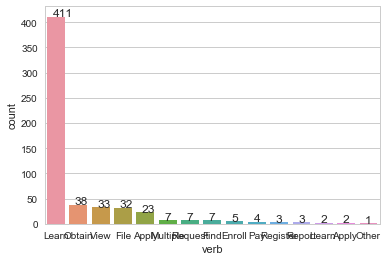

In [66]:
sns.set(style="whitegrid", color_codes=True)
ax = sns.countplot(x="verb", data=data[data['verb']!= ''],order = data[data['verb']!= '']['verb'].value_counts().index)
for p, label in zip(ax.patches, data[data['verb']!= '']['verb'].value_counts().values):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

In [262]:
data.pdf_count.value_counts().sort_values(ascending=False)

0       4030
1        530
2        390
3        167
4        120
5        102
6         95
7         73
8         55
20        55
9         43
11        37
12        35
10        34
15        27
19        24
16        23
14        17
26        15
21        15
13        15
22        14
17        14
33        14
31        12
29        11
23        11
18        11
40        10
28        10
25        10
27         9
32         9
43         9
30         9
51         9
38         8
24         7
45         7
39         7
35         7
36         7
34         6
49         5
44         5
42         5
48         5
41         4
37         4
54         4
57         4
68         4
53         4
52         3
162        3
55         3
62         3
85         3
63         3
65         2
141        2
56         2
154        2
105        2
147        2
46         2
107        2
163        2
84         2
118        2
103        2
59         2
79         2
50         2
83         2
116        2
94         1

In [314]:
data['description_words'] = data.description_words.fillna('')
data['len'] = data.description_words.apply(lambda x: len(x))
count = list(data.groupby('dept_name')['len'].agg(['count'])['count'])
summ = list(data.groupby('dept_name')['len'].agg(['sum'])['sum'])
density = []
for i, c in enumerate(count):
    density.append(round((summ[i]/c),0))
deptn = list(data.groupby('dept_name')['len'].agg(['sum']).index)
for i, d in enumerate(density):
    print((deptn[i], d))


('311 City Services', 1515.0)
('Board of Ethics', 1664.0)
('Chicago Fire Department', 1776.0)
('Chicago Police Board', 718.0)
('Chicago Police Department', 155.0)
('Chicago Public Library', 253.0)
('City of Chicago TV', 193.0)
('Civilian Office of Police Accountability', 812.0)
('Commission on Human Relations', 1306.0)
('Department of Administrative Hearings', 1935.0)
('Department of Animal Care and Control', 824.0)
('Department of Aviation', 318.0)
('Department of Buildings', 1132.0)
('Department of Business Affairs and Consumer Protection', 1835.0)
('Department of Compliance', 13.0)
('Department of Cultural Affairs and Special Events', 2039.0)
('Department of Family & Support Services', 1267.0)
('Department of Finance', 1015.0)
('Department of Fleet and Facility Management', 738.0)
('Department of Human Resources', 258.0)
('Department of Innovation and Technology', 718.0)
('Department of Law', 532.0)
('Department of Planning and Development', 1430.0)
('Department of Procurement Servi

In [335]:
viz2(data.groupby('dept_name')['pdf_count'].agg(['sum']).sort_values(by='sum',ascending=False), title="Number of PDFs by Department", xaxis = 'Department',xsize=8, yaxis='Number of PDFs')

In [390]:
svcs = data[~data.in_directory.isnull()][['dept_name','title','url','button','services','ext_links','in_directory']]

In [402]:
viz(svcs.groupby('dept_name').size().sort_values(ascending=False),title='Number of Services by Department',xaxis='Department',yaxis='Number of Services',xsize=8)